In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torch.utils.data.dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
from matplotlib import pyplot as plt

In [3]:
import time
from tqdm.notebook import tqdm
import copy

import torch
from torch import nn
import torch.utils.data.dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets


def get_datasets():
    """ Returns train and validation datasets. """
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    data_transforms = [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std), transforms.Grayscale()]

    dataset_class = datasets.CIFAR10
    def get_dataset(train: bool):  # Returns the train or validation dataset.
        root = "./data"
        kwargs = dict(root=root, transform=transforms.Compose(data_transforms), train=train, download=True)
        dataset = dataset_class(**kwargs)
        return dataset

    train_dataset = get_dataset(train=True)
    val_dataset = get_dataset(train=False)
    return train_dataset, val_dataset


def get_dataloaders(batch_size):
    """ Returns train and validation dataloaders. """
    train_dataset, val_dataset = get_datasets()

    def get_dataloader(dataset, shuffle):
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                                           num_workers=0, pin_memory=True)

    train_loader = get_dataloader(train_dataset, shuffle=True)
    val_loader = get_dataloader(val_dataset, shuffle=False)
    return train_loader, val_loader


def initialize_mlp_model(dims):
    """ Create a simple MLP model.
    :param dims: list of dimensions of each layer, should begin with dimension of input and end with number of classes.
    :return: Sequential MLP model
    """
    layers = [torch.nn.Flatten()]
    for i in range(len(dims) - 1):
        layers.append(nn.Linear(dims[i], dims[i + 1], bias=False))
        if i < len(dims) - 2:
            layers.append(nn.ReLU())
    model = nn.Sequential(*layers)
    return model


def initialize_cnn_model(channels, spatial_size=32, kernel_size=5, stride=2, num_classes=10):
    """ Create a simple CNN model.
    :param channels: list of channels of each convolutional layer, should begin with number of channels of input.
    :return Sequential CNN model
    """
    layers = []
    for i in range(len(channels) - 1):
        layers.append(nn.Conv2d(channels[i], channels[i + 1], kernel_size=5, stride=2, bias=False))
        spatial_size = ceil_div(spatial_size - kernel_size + 1, stride)
        layers.append(nn.ReLU())

    layers.extend([nn.Flatten(), nn.Linear(channels[-1] * spatial_size ** 2, num_classes, bias=False)])
    model = nn.Sequential(*layers)
    return model


def ceil_div(a: int, b: int) -> int:
    """ Return ceil(a / b). """
    return a // b + (a % b > 0)


'''def train_model(model, train_loader, val_loader, lr=0.01, momentum=0.9, num_epochs=5):
    """ Simple training of a model with SGD. """
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss()

    epoch = 0
    model.cuda()
    while True:
        # Evaluate on validation set.
        one_epoch(
            loader=val_loader, model=model, loss_fn=loss_fn,
            optimizer=optimizer, epoch=epoch, is_training=False,
        )

        # Stop if we are at the last epoch.
        if epoch == num_epochs:
            break

        # Train for one epoch (now epoch counts the current training epoch).
        epoch += 1
        one_epoch(
            loader=train_loader, model=model, loss_fn=loss_fn,
            optimizer=optimizer, epoch=epoch, is_training=True,
        )

    # Ensure evaluation mode and disable gradients before returning trained model.
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    return model'''


'''def one_epoch(loader, model, loss_fn, optimizer, epoch, is_training):
    """ Run one train or validation epoch on the model.
    :param loader: dataloader to use
    :param model: model to train or evaluate
    :param loss_fn: loss function (not used during evaluation)
    :param optimizer: optimizer (not used during evaluation)
    :param epoch: current epoch number (for tqdm description)
    :param is_training: whether to train the model or simply evaluate it
    :return: average accuracy during the epoch
    """
    name_epoch = "Train" if is_training else "Val"
    name_epoch = f"{name_epoch} epoch {epoch}"
    accuracy_meter = AverageMeter()

    if is_training:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(is_training):
        it = tqdm(loader, desc=name_epoch)
        for x, y in it:
            x = x.cuda(non_blocking=True)
            y = y.cuda(non_blocking=True)
            y_hat = model(x)

            loss = loss_fn(y_hat, y)
            accuracy = 100 * torch.sum((y_hat.argmax(-1) == y).float())
            accuracy_meter.update(val=accuracy.item(), n=y.shape[0])
            it.desc = f"{name_epoch}: {accuracy_meter.avg():.2f}% accuracy"

            if is_training:
                # compute gradient and do SGD step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    return accuracy_meter.avg()'''


class AverageMeter(object):
    """ Computes and stores the average and current value. """
    def __init__(self):
        self.sum = 0
        self.count = 0

    def update(self, val, n):
        self.sum += val
        self.count += n

    def avg(self):
        return self.sum / self.count


def get_activations(x, layers, model):
    """ Returns the hidden activations of a model.
    :param x: input to use, tensor of shape (B, C, [N, N])
    :param layers: list of integers (j corresponds to output of j-th layer, 0 corresponds to input of model)
    :param model: model to use (should be Sequential)
    :return: list of saved activations of same length as layers
    """
    saved_activations = []

    def hook(self, inputs, output):  # inputs is a tuple, we assume it is of length 1
        saved_activations.append(inputs[0])

    # Register hooks to save activations of chosen layers.
    for layer in layers:
        model[layer].register_forward_hook(hook)

    # Forward of model: hooks will be run and activations will be saved.
    _ = model(x)

    # Clear hooks.
    for layer in layers:
        model[layer]._forward_hooks.clear()

    return saved_activations


def compute_activation_covariances(loader, layers, model1, model2=None):
    """ Compute the (cross-)covariance of hidden activations at several layers of one or two models.
    :param loader: data loader to use
    :param layers: list of integers (j corresponds to output of j-th layer, 0 corresponds to input of model)
    :param model1: model to use (should be Sequential)
    :param model2: optional model for a cross-covariance (if None, compute the self-covariance of model1)
    :return: list of computed covariances (C1, C2), of same length as layers
    """
    meters = [AverageMeter() for _ in layers]

    # Version of get_activations which treats spatial dimensions as additional batch dimensions.
    get_acts = lambda *args: [space_to_batch(act) for act in get_activations(*args)]

    for x, _ in tqdm(loader, desc="Computing activation covariance"):
        x = x.cuda()
        activations1 = get_acts(x, layers, model1)
        activations2 = activations1 if model2 is None else get_acts(x, layers, model2)

        for i, (act1, act2) in enumerate(zip(activations1, activations2)):
            cov = act1.T @ act2  # (C1, C2), sum of outer products over the batch
            meters[i].update(val=cov, n=act1.shape[0])

    return [meter.avg() for meter in meters]


def space_to_batch(x):
    """ (B, C, [M, N]) to (B[MN], C). """
    if x.ndim == 4:
        x = x.permute(0, 2, 3, 1)  # (B, M, N, C)
        x = x.reshape((-1, x.shape[-1]))  # (BMN, C)
    return x


def clip(model, layer, basis, dimensions, loader):
    """ Clip and evaluate a model.
    :param model: trained model to clip (should be Sequential)
    :param layer: index of layer to clip
    :param basis: ordered orthogonal basis vectors for the clipping, of shape (num_vectors, input_dim)
    :param dimensions: list of clipping dimensions
    :param loader: data loader to use for the evaluation
    :return: list of accuracies
    """
    models = []
    for dim in dimensions:
        projector = basis[:dim].T @ basis[:dim]
        model_clipped = copy.deepcopy(model)
        model_clipped[layer].weight = torch.nn.Parameter(model_clipped[layer].weight @ projector, requires_grad=False)
        models.append(model_clipped)

    return evaluate(models, loader, desc="Evaluation after clipping")


def evaluate(models, loader, desc="Evaluation"):
    """ Evaluate a list of models.
    :param models: list of models to evaluate
    :param loader: dataloader to use for evaluation
    :return: list of accuracies, one per model
    """
    accuracy_meters = [AverageMeter() for _ in models]

    it = tqdm(loader, desc=desc)
    for x, y in it:
        x = x.cuda(non_blocking=True)
        y = y.cuda(non_blocking=True)
        for model, accuracy_meter in zip(models, accuracy_meters):
            y_hat = model(x)
            accuracy = 100 * torch.sum((y_hat.argmax(-1) == y).float())
            accuracy_meter.update(val=accuracy.item(), n=y.shape[0])

    return [accuracy_meter.avg() for accuracy_meter in accuracy_meters]


def resample(reference_model, state_dict_keys, train_loader, val_loader):
    """ Resample a given network or ensemble of networks.
    NOTE: this function does not take care of batch norm parameters.
    They should be recomputed when the previous layer has been resampled.
    NOTE: this function can be extended in many ways: resample only a subset of layers, change the width of some layers,
    use weight covariances averaged over several models...
    :param reference_model: reference model to resample
    :param state_dict_keys: list of keys in model state dict to resample
    :param train_loader: dataloader used for computing alignment between reference and resampled model
    :param val_loader: dataloader used to evaluate performance of resampled model
    :return: list of accuracies, corresponding to the reference and resampled models
    """
    # The resampled model is initialized as a copy of the reference model.
    resampled_model = copy.deepcopy(reference_model)
    state_dict = resampled_model.state_dict()

    # At beginning of loop, this contains alignment at layer j between resampled model and reference model
    # (used to determine the correct covariance to resample atoms at layer j).
    alignment = None  # alignment matrix (C_in_reference, C_in_resample)

    results = {}  # metric, layer_idx -> performance

    # Resample each layer iteratively.
    for j, key in enumerate(state_dict_keys):
        weight = state_dict[key]  # (C_out, C_in, [h, w]) depending on conv or fully connected layer

        # Compute new weight in reference space.
        if j < len(state_dict_keys) - 1:
            # Sample Gaussian weights with the same covariance as the trained weights.
            # Compute square root of covariance with an SVD (more efficient when C_out << C_in*h*w).
            weight_flat = weight.reshape((weight.shape[0], -1))  # (C_out, C_in*h*w)
            u, s, vt = torch.linalg.svd(weight_flat, full_matrices=False)  # (C_out, R), (R,), (R, C_in*h*w) where R = rank
            white_gaussian = torch.randn(u.shape, dtype=weight.dtype, device=weight.device)  # (C_out, R)
            colored_gaussian = white_gaussian @ (s[:, None] * vt)  # (C_out, C_in*h*w)
            new_weight = colored_gaussian.reshape(weight.shape)  # (C_out, C_in, [h, w])
        else:
            # Use the trained classifier.
            new_weight = weight

        # Realign the weights from the reference model to the resampled model (necessary after first layer).
        if j > 0:
            new_weight = contract(new_weight, alignment.T, axis=1)  # C_in_reference to C_in_resampled

        # Set the new weights in the resampled model.
        # NOTE: this an intermediate model, as resampling the j-th layer means that the j+1-th layer is no longer aligned.
        # As such, if evaluated as is, its accuracy would be that of a random guess.
        state_dict[key] = new_weight
        resampled_model.load_state_dict(state_dict)

        # Then compute alignment of the resampled network with the reference model for the next layer.
        if j < len(state_dict_keys) - 1:
            next_key = state_dict_keys[j + 1]
            # Compute index of layer by relying on Sequential naming convention: next_key is "{layer_idx}.weight".
            layer = int(next_key.split(".")[0])

            [activation_covariance] = compute_activation_covariances(
                train_loader, [layer], reference_model, resampled_model)  # (C_in_reference, C_in_resampled)

            u, s, vh = torch.linalg.svd(activation_covariance, full_matrices=False)  # (C_in_reference, R), (R,), (R, C_in_resampled)
            alignment = u @ vh  # (C_in_reference, C_in_resampled)

    # Evaluate models.
    return evaluate([reference_model, resampled_model], val_loader, desc="Evaluation after resampling")


def contract(tensor, matrix, axis):
    """ tensor is (..., D, ...), matrix is (P, D), returns (..., P, ...). """
    t = torch.moveaxis(tensor, source=axis, destination=-1)  # (..., D)
    r = t @ matrix.T  # (..., P)
    return torch.moveaxis(r, source=-1, destination=axis)  # (..., P, ...)

In [4]:
def one_epoch(loader, model, loss_fn, optimizer, epoch, is_training,
              record_steps=False, step_activation_history=None, step_weight_history=None,
              update_parameters=True):
    from tqdm import tqdm

    name_epoch = "Train" if is_training else "Val"
    name_epoch = f"{name_epoch} epoch {epoch}"
    accuracy_meter = AverageMeter()

    if is_training:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(is_training):
        it = tqdm(loader, desc=name_epoch)
        for x, y in it:
            x = x.cuda(non_blocking=True)
            y = y.cuda(non_blocking=True)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            accuracy = 100 * torch.sum((y_hat.argmax(dim=-1) == y).float())
            accuracy_meter.update(val=accuracy.item(), n=y.shape[0])
            it.desc = f"{name_epoch}: {accuracy_meter.avg():.2f}% accuracy"

            if is_training:
                if update_parameters:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                if record_steps:
                    with torch.no_grad():
                        act_layers = [3, 5]
                        weight_layers = [1, 3]


                        activations = get_activations(x, act_layers, model)
                        activations = [space_to_batch(act) for act in activations]
                        step_act_eigs = []
                        for act in activations:
                            cov = act.T @ act
                            eigvals = torch.linalg.eigvalsh(cov).flip(-1)
                            step_act_eigs.append(eigvals.detach().cpu().numpy())

                        step_weight_eigs = []
                        for l in weight_layers:
                            weight_matrix = model[l].weight
                            sv = torch.linalg.svdvals(weight_matrix)
                            eigvals_w = (sv**2 / weight_matrix.shape[0]).detach().cpu().numpy()
                            step_weight_eigs.append(eigvals_w)

                        step_activation_history.append(step_act_eigs)
                        step_weight_history.append(step_weight_eigs)
    return accuracy_meter.avg()

In [5]:
def train_model(model, train_loader, val_loader, lr=0.01, momentum=0.9, num_epochs=5):

    import torch
    from torch import nn

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss()

    step_activation_history_by_epoch = {}
    step_weight_history_by_epoch = {}

    epoch = 0
    model.cuda()
    for param in model.parameters():
        param.requires_grad = True

    step_act_history = []
    step_weight_history = []
    initial_accuracy = one_epoch(loader=train_loader, model=model, loss_fn=loss_fn, optimizer=optimizer,
                                 epoch=0, is_training=True, record_steps=True,
                                 step_activation_history=step_act_history, step_weight_history=step_weight_history,
                                 update_parameters=False)
    step_activation_history_by_epoch[0] = step_act_history
    step_weight_history_by_epoch[0] = step_weight_history
    print(f"Epoch 0: Training Accuracy (initial state) = {initial_accuracy:.2f}%")

    while True:
        val_accuracy = one_epoch(loader=val_loader, model=model, loss_fn=loss_fn, optimizer=optimizer,
                                 epoch=epoch, is_training=False)
        print(f"Epoch {epoch}: Validation Accuracy = {val_accuracy:.2f}%")

        if epoch == num_epochs:
            break

        epoch += 1
        if epoch <= 1:

            step_act_history = []
            step_weight_history = []
            train_accuracy = one_epoch(loader=train_loader, model=model, loss_fn=loss_fn, optimizer=optimizer,
                                       epoch=epoch, is_training=True, record_steps=True,
                                       step_activation_history=step_act_history, step_weight_history=step_weight_history,
                                       update_parameters=True)
            step_activation_history_by_epoch[epoch] = step_act_history
            step_weight_history_by_epoch[epoch] = step_weight_history
        else:
            train_accuracy = one_epoch(loader=train_loader, model=model, loss_fn=loss_fn, optimizer=optimizer,
                                       epoch=epoch, is_training=True)
        print(f"Epoch {epoch}: Training Accuracy = {train_accuracy:.2f}%")

    model.eval()
    for param in model.parameters():
        param.requires_grad = False

    return model, step_activation_history_by_epoch, step_weight_history_by_epoch

In [46]:
def plot_activation_history(step_activation_history_by_epoch, normalize=True, y_min=1e-3):
    """
    Combine activation spectra from epoch 0 and epoch 1, treating epoch 0 as step 0 and epoch 1's steps as subsequent steps.
    If there are more than 20 steps recorded, sub-sample using a fixed interval (e.g. every 30 steps).
    For each monitored layer, plot the eigenvalues on a log-log scale.
    The parameter `normalize` controls whether to normalize each eigenvalue sequence by its maximum value.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    cmap = plt.get_cmap("viridis")

    # Combine records from epoch 0 and epoch 1
    combined_history = []
    if 0 in step_activation_history_by_epoch:
        combined_history.extend(step_activation_history_by_epoch[0])
    if 1 in step_activation_history_by_epoch:
        combined_history.extend(step_activation_history_by_epoch[1])

    if not combined_history:
        print("No activation records available.")
        return

    n_steps = len(combined_history)
    num_layers = len(combined_history[0])

    # Sub-sample steps every 30 steps
    if n_steps > 20:
        step_indices = np.arange(0, n_steps, 30)
    else:
        step_indices = np.arange(n_steps)

    # For each monitored layer, plot the (optionally normalized) eigenvalues for the selected steps.
    for layer_idx in range(num_layers):
        plt.figure()
        n_plots = len(step_indices)
        for i, step_idx in enumerate(step_indices):
            record = combined_history[step_idx]
            eigvals = record[layer_idx]
            if normalize:
                max_val = eigvals[0] if eigvals[0] != 0 else 1.0
                plot_eigvals = eigvals / max_val
            else:
                plot_eigvals = eigvals
            plot_eigvals = np.clip(plot_eigvals, 1e-12, None)

            x = np.arange(1, len(plot_eigvals) + 1)
            logx = np.log10(x)
            logy = np.log10(plot_eigvals)
            slope, intercept = np.polyfit(logx, logy, 1)

            color = cmap(i / (n_plots - 1)) if n_plots > 1 else cmap(0)
            plt.plot(x, plot_eigvals, color=color, label=f"Step {step_idx} (slope: {slope:.2f})")

        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Rank")
        plt.ylabel("Normalized Eigenvalue" if normalize else "Eigenvalue")
        plt.ylim(bottom=y_min)
        plt.title(f"Combined Activation Covariance Eigenvalues (Layer {layer_idx + 1})")
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        plt.show()


In [67]:
def plot_weight_history(step_weight_history_by_epoch, normalize=True, y_min=1e-1):

    cmap = plt.get_cmap("viridis")

    combined_history = []
    if 0 in step_weight_history_by_epoch:
        combined_history.extend(step_weight_history_by_epoch[0])
    if 1 in step_weight_history_by_epoch:
        combined_history.extend(step_weight_history_by_epoch[1])

    if not combined_history:
        print("No weight records available.")
        return

    n_steps = len(combined_history)
    num_layers = len(combined_history[0])

    step_indices = np.arange(0, n_steps, 30)

    for layer_idx in range(num_layers):
        plt.figure()
        n_plots = len(step_indices)
        for i, step_idx in enumerate(step_indices):
            record = combined_history[step_idx]
            eigvals = record[layer_idx]

            if normalize:
                max_val = eigvals[0] if eigvals[0] != 0 else 1.0
                y_plot = eigvals / max_val
            else:
                y_plot = eigvals
            y_plot = np.clip(y_plot, 1e-12, None)
            x = 1 + np.arange(len(y_plot))
            logx = np.log10(x)
            logy = np.log10(y_plot)
            slope, intercept = np.polyfit(logx, logy, 1)

            color = cmap(i / (n_plots - 1)) if n_plots > 1 else cmap(0)
            plt.plot(x, y_plot, color=color, label=f"Step {step_idx} (slope: {slope:.2f})")

        plt.yscale("log")
        plt.xlabel("Rank")
        plt.ylabel("Normalized Eigenvalue" if normalize else "Eigenvalue")
        plt.ylim(bottom=y_min)
        plt.title(f"Combined Weight Matrix Eigenvalues (Layer {layer_idx + 1})")
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        plt.show()

In [49]:
def plot_global_activation_eigenvalues(activation_covariances, normalize=True):

    for layer_idx in range(len(activation_covariances)):
        activation_covariance = activation_covariances[layer_idx]
        activation_eigenvalues = torch.linalg.eigvalsh(activation_covariance).flip(-1)
        y = activation_eigenvalues.cpu().numpy()

        if normalize:
            max_val = y[0] if y[0] != 0 else 1.0
            y_plot = y / max_val
        else:
            y_plot = y

        y_plot = np.clip(y_plot, 1e-12, None)

        x = 1 + np.arange(len(y_plot))

        logx = np.log10(x)
        logy = np.log10(y_plot)
        slope, intercept = np.polyfit(logx, logy, 1)
        print(f"Layer {layer_idx+1} slope: {slope:.2f}")

        plt.figure()
        plt.title(f"Activation covariance eigenvalues (Layer {layer_idx+1})")
        plt.plot(x, y_plot, label=f"Slope: {slope:.2f}")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Rank")
        plt.ylabel("Normalized Eigenvalue" if normalize else "Eigenvalue")
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        plt.show()


In [77]:
def plot_global_weight_eigenvalues(dims, model, normalize=False):
    for layer_idx in range(2):
        weight_matrix = model[2 * layer_idx + 1].weight
        weight_eigenvalues = torch.linalg.svdvals(weight_matrix) ** 2 / weight_matrix.shape[0]

        init_weight_matrix = initialize_mlp_model(dims)[2 * layer_idx + 1].weight
        init_eigenvalues = torch.linalg.svdvals(init_weight_matrix) ** 2 / weight_matrix.shape[0]
        init_eigenvalues = init_eigenvalues.to(weight_eigenvalues.device)

        if normalize:
            max_val = weight_eigenvalues[0] if weight_eigenvalues[0] != 0 else 1.0
            weight_eigenvalues = weight_eigenvalues / max_val
            init_eigenvalues = init_eigenvalues / max_val
        plt.figure()
        plt.title(f"Weight covariance eigenvalues (layer {layer_idx + 1})")
        y = weight_eigenvalues.cpu().numpy()
        x = 1 + np.arange(len(y))

        logx = np.log10(x)
        logy = np.log10(y)
        slope, intercept = np.polyfit(logx, logy, 1)
        print(f"Layer {layer_idx+1} slope: {slope:.2f}")

        plt.plot(x, y, label="Current")
        plt.plot(x, init_eigenvalues.detach().cpu().numpy(), linestyle="dashed", color="C0", label="Init")
        plt.yscale("log")
        plt.xlabel("Rank")
        plt.ylabel("Normalized Eigenvalue" if normalize else "Eigenvalue")
        plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
        plt.show()

100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


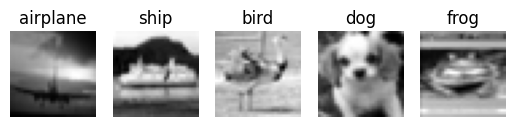

In [8]:
train_loader, val_loader = get_dataloaders(batch_size=128)
class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Draw one batch to show some training images
x, y = next(train_loader.__iter__())

fig, ax = plt.subplots(ncols=5)
for i in range(5):
    ax[i].imshow(x[i].cpu().numpy().transpose(1, 2, 0), cmap="gray")
    ax[i].axis("off")
    ax[i].set_title(class_labels[y[i]])

In [9]:
# dims = [32 * 32, 2048, 4096, 10]
dims = [32 * 32, 512, 256, 10]
model = initialize_mlp_model(dims)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=512, bias=False)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=False)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=False)
)


In [10]:
model, step_activation_history_by_epoch, step_weight_history_by_epoch = train_model(model, train_loader, val_loader, num_epochs=5)

Train epoch 0: 11.61% accuracy: 100%|██████████| 391/391 [00:41<00:00,  9.37it/s]


Epoch 0: Training Accuracy (initial state) = 11.61%


Val epoch 0: 11.50% accuracy: 100%|██████████| 79/79 [00:02<00:00, 26.67it/s]


Epoch 0: Validation Accuracy = 11.50%


Train epoch 1: 30.87% accuracy: 100%|██████████| 391/391 [00:41<00:00,  9.40it/s]


Epoch 1: Training Accuracy = 30.87%


Val epoch 1: 35.48% accuracy: 100%|██████████| 79/79 [00:03<00:00, 24.63it/s]


Epoch 1: Validation Accuracy = 35.48%


Train epoch 2: 38.57% accuracy: 100%|██████████| 391/391 [00:15<00:00, 24.98it/s]


Epoch 2: Training Accuracy = 38.57%


Val epoch 2: 39.09% accuracy: 100%|██████████| 79/79 [00:02<00:00, 27.18it/s]


Epoch 2: Validation Accuracy = 39.09%


Train epoch 3: 42.14% accuracy: 100%|██████████| 391/391 [00:16<00:00, 23.96it/s]


Epoch 3: Training Accuracy = 42.14%


Val epoch 3: 41.03% accuracy: 100%|██████████| 79/79 [00:02<00:00, 26.50it/s]


Epoch 3: Validation Accuracy = 41.03%


Train epoch 4: 45.26% accuracy: 100%|██████████| 391/391 [00:15<00:00, 25.23it/s]


Epoch 4: Training Accuracy = 45.26%


Val epoch 4: 42.74% accuracy: 100%|██████████| 79/79 [00:02<00:00, 26.80it/s]


Epoch 4: Validation Accuracy = 42.74%


Train epoch 5: 47.91% accuracy: 100%|██████████| 391/391 [00:16<00:00, 23.13it/s]


Epoch 5: Training Accuracy = 47.91%


Val epoch 5: 41.78% accuracy: 100%|██████████| 79/79 [00:02<00:00, 27.36it/s]

Epoch 5: Validation Accuracy = 41.78%


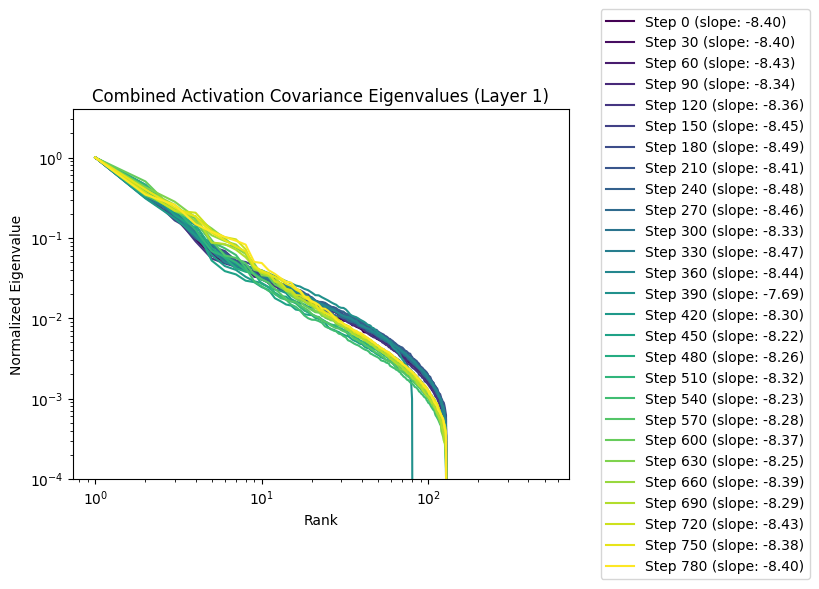

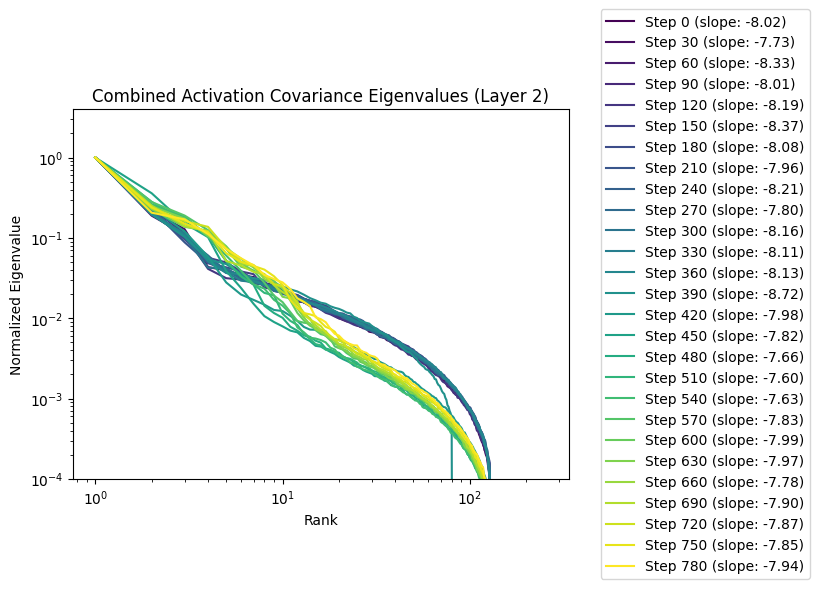

In [79]:
plot_activation_history(step_activation_history_by_epoch, True, y_min=1e-4)

In [12]:
layers = [3, 5]
activation_covariances = compute_activation_covariances(train_loader, layers, model)


Computing activation covariance:   0%|          | 0/391 [00:00<?, ?it/s]

Layer 1 slope: -1.40


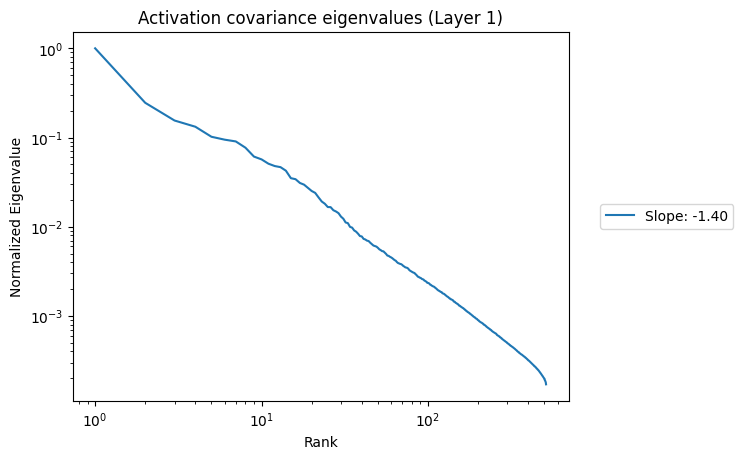

Layer 2 slope: -1.40


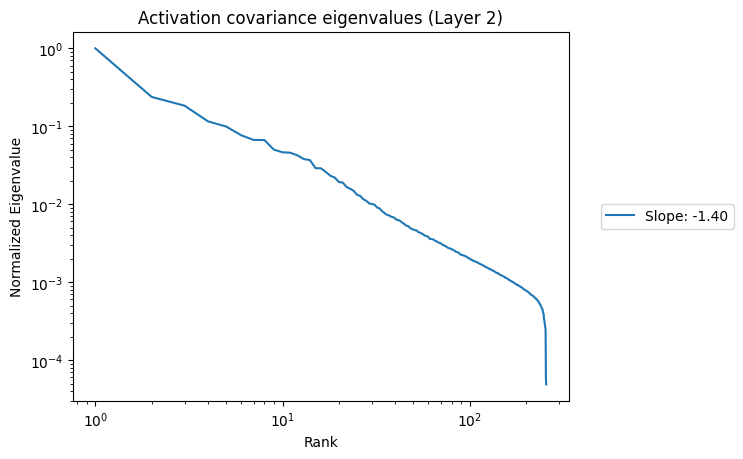

In [52]:
plot_global_activation_eigenvalues(activation_covariances, normalize=True)

Evaluation after clipping:   0%|          | 0/79 [00:00<?, ?it/s]

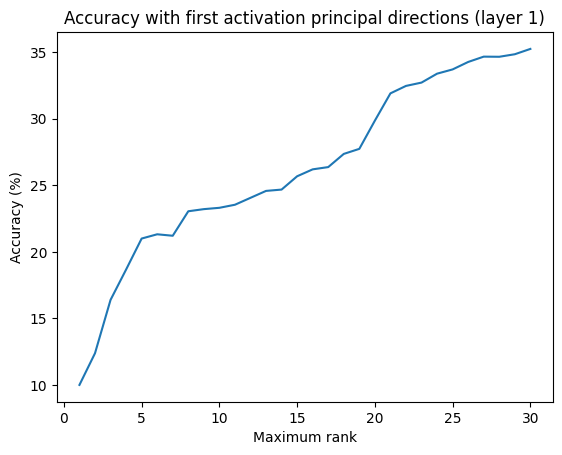

Evaluation after clipping:   0%|          | 0/79 [00:00<?, ?it/s]

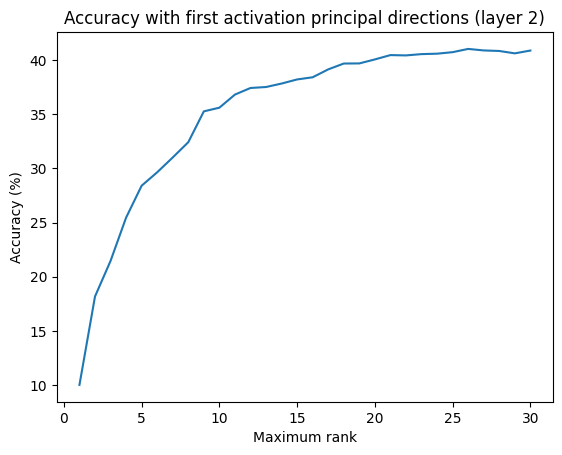

In [21]:
# Clipping analysis.
for layer_idx in range(2):
    activation_covariance = activation_covariances[layer_idx]
    basis = torch.linalg.eigh(activation_covariance).eigenvectors.flip(-1).T  # (num_eig, dim), descending order
    dimensions = list(range(1, 31))
    accuracies = clip(model, 2 * layer_idx + 3, basis, dimensions, val_loader)

    plt.figure()
    plt.plot(dimensions, accuracies)
    plt.title(f"Accuracy with first activation principal directions (layer {layer_idx + 1})")
    plt.xlabel("Maximum rank")
    plt.ylabel(r"Accuracy (%)")
    plt.show()

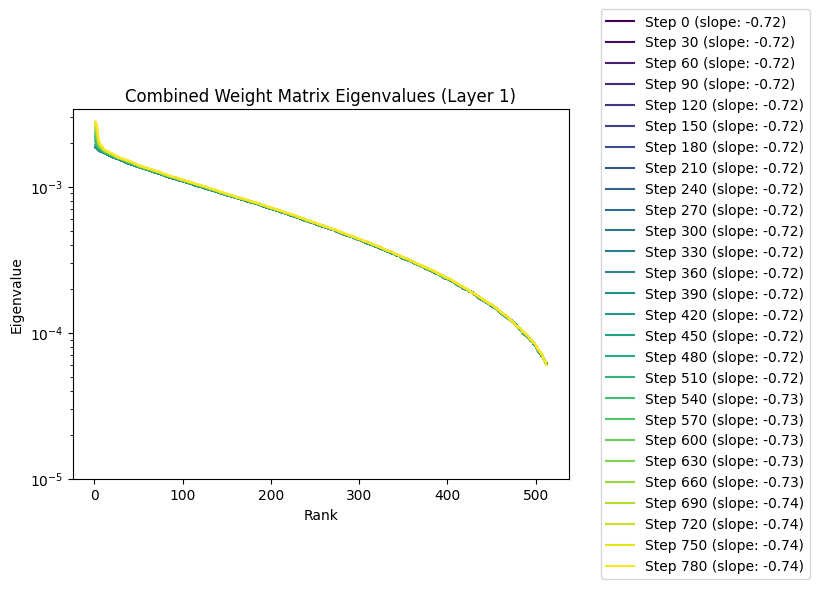

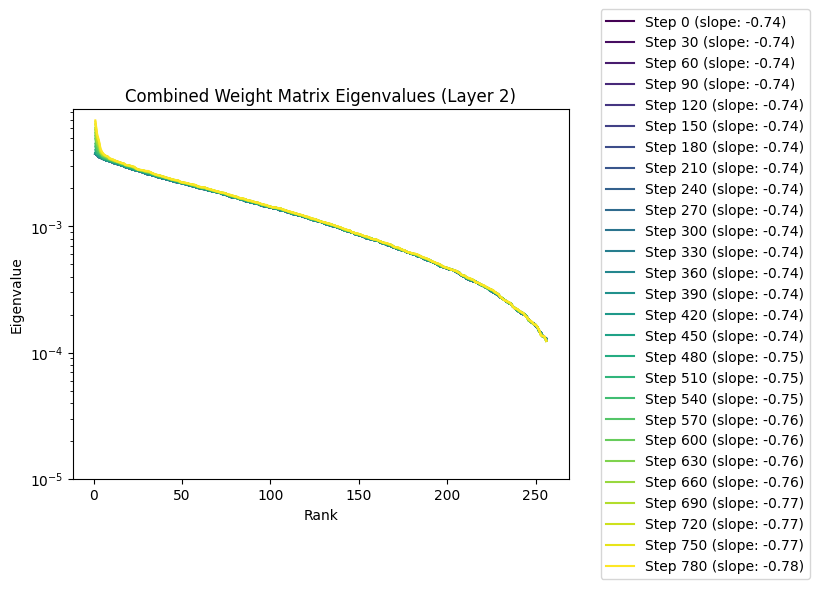

In [70]:
plot_weight_history(step_weight_history_by_epoch, normalize=False, y_min=1e-5)

Layer 1 slope: -0.87


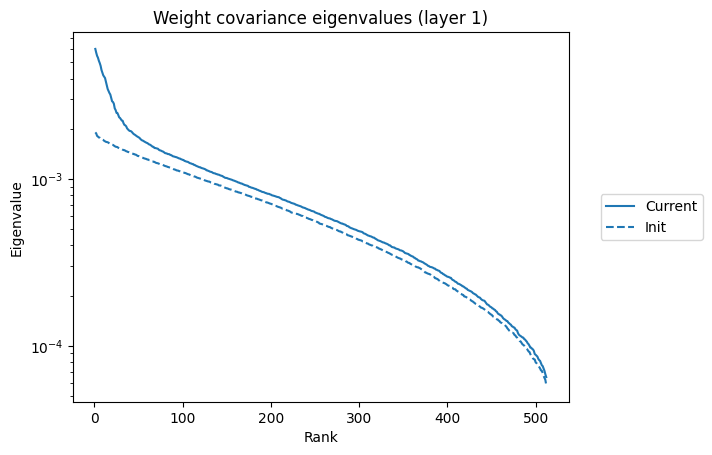

Layer 2 slope: -0.89


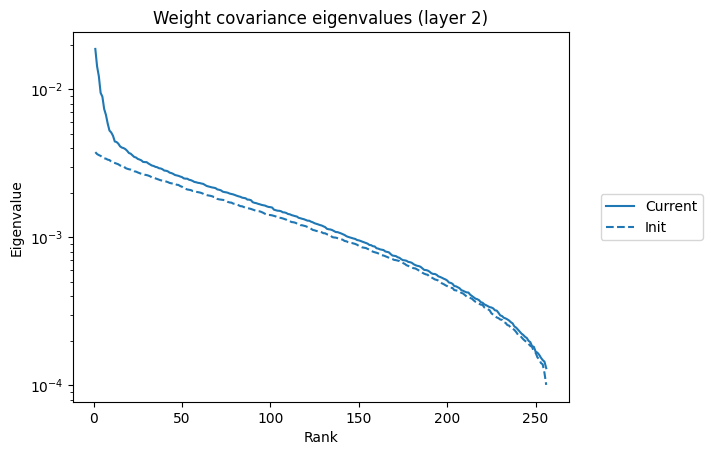

In [78]:
plot_global_weight_eigenvalues(dims, model, normalize=False)

Evaluation after clipping:   0%|          | 0/79 [00:00<?, ?it/s]

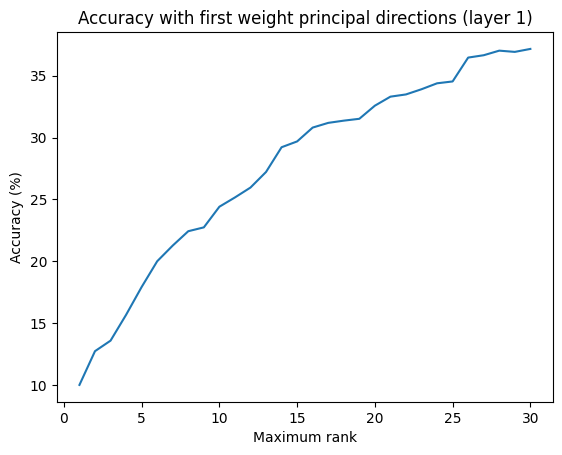

Evaluation after clipping:   0%|          | 0/79 [00:00<?, ?it/s]

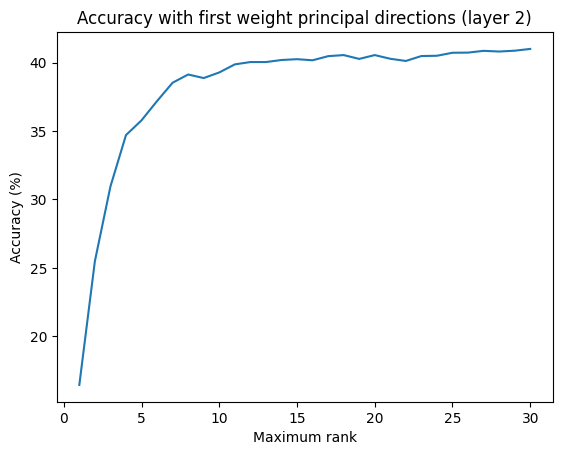

In [33]:
for layer_idx in range(2):
    weight_matrix = model[2 * layer_idx + 1].weight  # (N, D)
    # Compute eigenvalues of weight covariance efficiently from the SVD.
    basis = torch.linalg.svd(weight_matrix).Vh
    dimensions = list(range(1, 31))
    accuracies = clip(model, 2 * layer_idx + 1, basis, dimensions, val_loader)

    plt.figure()
    plt.plot(dimensions, accuracies)
    plt.title(f"Accuracy with first weight principal directions (layer {layer_idx + 1})")
    plt.xlabel("Maximum rank")
    plt.ylabel(r"Accuracy (%)")
    plt.show()